## 1. Data pre-processing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### 1.1 Train/Dev/Test split

In [2]:
from sklearn.model_selection import train_test_split

The dataset has been already splitted into train and test sets, with a ratio of about 70/30%. 

For our classification task, in order to fine tune the hyperparameters of the model and select the best features from the data, we further split those sets. So, we end up with train, evaluation and test sets of about 60/20/20% of the overall data, respectively.

In [3]:
dataset = pd.read_csv('./data/dataset.csv')

In [4]:
# take 2/5 of the train set for cross validation and test
train_set, dev_test_set = train_test_split(dataset, test_size=0.4, random_state=12)

# take 1/2 of the test set for cross validation
test_set, dev_set = train_test_split(dev_test_set, test_size=0.5, random_state=12)

In [5]:
train_set.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
6505,0.278909,-0.016122,-0.108804,-0.991421,-0.958884,-0.943642,-0.992854,-0.959690,-0.944281,-0.926421,...,-0.604272,-0.135149,-0.006428,-0.840651,0.548457,-0.690776,0.291574,0.110070,28,SITTING
4384,0.278544,-0.017497,-0.111402,-0.997560,-0.980832,-0.987017,-0.997578,-0.979116,-0.988149,-0.942968,...,-0.919445,-0.089110,-0.044198,-0.607149,0.601884,-0.817034,0.214795,-0.032885,22,STANDING
7480,0.243931,-0.004004,-0.122676,-0.092084,0.010789,0.199388,-0.193510,-0.041149,0.186226,0.315973,...,-0.639589,0.368217,0.310372,0.969768,-0.504041,-0.496266,0.268661,0.327231,2,WALKING_DOWNSTAIRS
5960,0.278354,-0.016345,-0.111278,-0.985230,-0.988805,-0.990760,-0.985383,-0.987864,-0.990653,-0.930099,...,-0.950759,0.332895,0.404353,0.222148,0.056738,0.604472,-0.363929,-0.648498,27,LAYING
10196,0.291115,-0.014618,-0.112456,-0.968179,-0.982618,-0.983055,-0.967095,-0.982565,-0.980663,-0.916381,...,-0.940910,-0.090369,0.008545,0.387679,-0.204587,0.449349,-0.501789,-0.490746,24,LAYING


Create the `numpy` representation from the `pandas.DataFrame` objects.

In [6]:
y_train_set = train_set[['Activity']].values.ravel()
x_train_set = train_set.drop(['Activity','subject'], axis=1).values

x_dev_set = dev_set.drop(['Activity','subject'], axis=1).values
y_dev_set = dev_set[['Activity']].values.ravel()

x_test_set = test_set.drop(['Activity','subject'], axis=1).values
y_test_set = test_set[['Activity']].values.ravel()

### 1.2 Feature selection

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

The feature selection has the purpose to retain from the data only those features that are the most relevant, i.e. useful, purging the data from those which add few or no significant improvement.

Dimensionality reduction is different from feature selection, cause it projects the data in a new space, giving as a result a set of new features, whereas feature selection filters out the original features.

Feature selection is carried out by statical analyses, such as correlation analysis. For classification tasks on numerical data the ANOVA statistical model is known to be quite good. Then, we leverage its implementation in sklearn.

In [8]:
fs = SelectKBest(score_func=f_classif, k=300)

In [9]:
y_train_set_s = train_set[['Activity']].values.ravel()
x_train_set_s = fs.fit_transform(train_set.drop(['Activity','subject'], axis=1).values, y_train_set)

x_dev_set_s = fs.transform(dev_set.drop(['Activity','subject'], axis=1))
y_dev_set_s = dev_set[['Activity']].values.ravel()

x_test_set_s = fs.transform(test_set.drop(['Activity','subject'], axis=1))
y_test_set_s = test_set[['Activity']].values.ravel()

We can see which features are kept:

In [10]:
train_set.drop(['Activity','subject'], axis=1).columns[fs.get_support() == True]

Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z',
       'tBodyAcc-min()-X',
       ...
       'fBodyBodyGyroJerkMag-std()', 'fBodyBodyGyroJerkMag-mad()',
       'fBodyBodyGyroJerkMag-max()', 'fBodyBodyGyroJerkMag-min()',
       'fBodyBodyGyroJerkMag-sma()', 'fBodyBodyGyroJerkMag-iqr()',
       'fBodyBodyGyroJerkMag-entropy()', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=300)

### 1.3 Dimensionality reduction

As an alternative step to the feature selection, we consider the dimensionality reduction in order to project the original feature space into a new lower-dimensional feature space. Even in this case, we leverage the objects of the `sklearn` library.

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
svd = TruncatedSVD(n_components=200)
x_train_set_r = svd.fit_transform(x_train_set)
x_dev_set_r = svd.transform(x_dev_set)
x_test_set_r = svd.transform(x_test_set)

We check how much variance is retained with the number of components we chose.

In [16]:
np.sum(svd.explained_variance_ratio_) * 100

99.99572513060758

### 1.4 Encoding Labels

We encode the activity labels to numerical labels.

In [17]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()
y_train_set = le.fit_transform(y_train_set)

le = preprocessing.LabelEncoder()
y_dev_set = le.fit_transform(y_dev_set)

le = preprocessing.LabelEncoder()
y_test_set = le.fit_transform(y_test_set)

See the actual corresponding classes.

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}


## 2. Models

### 2.1 GDA

As the first model, we focus on the Gaussian Discriminant Analysis model. Indeed, we want to compare in the end the results of our model with those provided in the paper "Activity Classification with Smartphone Data".

For the GDA, we provide a custom implementation, that is inspired by Bam Tak's.

In [19]:
def gda(x, y, x_test, y_test, eval_score=False):
    y_classes, y_counts = np.unique(y, return_counts=True)
    p_y = 1.0 * y_counts/len(y)
    mu = np.array([ x[y==k].mean(axis=0) for k in y_classes])
    sigma = compute_sigma(x, y, mu, y_classes)
    #adding noise
    sigma += np.ones_like(sigma) * 1e-10
    sigma = np.linalg.pinv(sigma)
    if eval_score:
        return score(x_test, y_test, mu, sigma, p_y)
    return predict(x_test, mu, sigma, p_y)

def compute_sigma(x, y, mu, y_classes):
    x_u = x.copy()
    for i in range(len(mu)):
        x_u[y==y_classes[i]] -= mu[i]
    return x_u.T.dot(x_u) / len(y)
    
def predict(data, mu, sigma, p_y):
    return np.apply_along_axis(lambda x: (np.argmax(np.exp(-0.5 * np.sum((x - mu).dot(sigma) * (x - mu), axis =1)) * p_y)), 1, data)

def score(x, y, mu, sigma, p_y):
    return (predict(x, mu, sigma, p_y) == y).mean()

Let's try the model on the evaluation set.

In [20]:
gda(x_train_set, y_train_set, x_dev_set, y_dev_set, eval_score=True)

0.9640776699029127

Then, let's see the performance of GDA on the test set.

In [21]:
model = gda(x_train_set, y_train_set, x_test_set, y_test_set, eval_score=True)

In [22]:
model

0.9577669902912621

In the following section, we will look for the number of features that will give us the best performance.

### 2.2 SVM

The second model we are going to apply is the Support Vector Machine model. 

We reviewed and dived into the optimization techniques of SVM. Even thought we tried to implement SVM from scratch, following the Platt's SMO algorithm, for the analysis on our dataset we leverage the SVM implementation of `sklearn` library.

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
svclassifier = SVC(kernel='rbf', C=100.0, gamma=0.1)
svclassifier.fit(x_train_set, y_train_set)

SVC(C=100.0, gamma=0.1)

We apply the trained model to the evaluation set and we print the performance scores.

In [28]:
y_pred = svclassifier.predict(x_dev_set)

In [29]:
print(confusion_matrix(y_dev_set,y_pred))
print()
print(classification_report(y_dev_set,y_pred))

[[386   0   0   0   5   0]
 [  0 337   9   0   2   0]
 [  0   6 359   0   0   0]
 [  0   0   0 366   1   0]
 [  0   0   0   1 288   0]
 [  0   0   0   1   1 298]]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       391
           1       0.98      0.97      0.98       348
           2       0.98      0.98      0.98       365
           3       0.99      1.00      1.00       367
           4       0.97      1.00      0.98       289
           5       1.00      0.99      1.00       300

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



## 3. Models tuning

At this point, we consider again the models we are going to train: GDA and SVM. We want to find the most convenient configuration of the data-model system in terms of performance. 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

### 3.1 GDA tuning

With the functions below we apply different combinations of features selection and dimensionality reduction steps.

We try to combine both of the techniques or to apply just one of them.

In [51]:
def select_features(train_set, dev_set, n_features):
    global y_train_set
    fs = SelectKBest(score_func=f_classif, k=n_features)
    x_train_s = fs.fit_transform(train_set.drop(['Activity','subject'], axis=1).values, y_train_set)
    x_dev_s = fs.transform(dev_set.drop(['Activity','subject'], axis=1))
    return x_train_s, x_dev_s


def reduce_features(x_train, x_dev, n_components):
    svd = TruncatedSVD(n_components=n_components)
    x_train_r = svd.fit_transform(x_train)
    x_dev_r = svd.transform(x_dev)
    return x_train_r, x_dev_r


def tune_model_gda(train_set, dev_set):
    log_result = {}
    global y_train_set, y_dev_set
    for n_features in tqdm((50, 100, 300, 400, 561)):
        log_result[n_features] = {}
        x_train_select, x_dev_select = select_features(train_set, dev_set, n_features)
        for n_components in range(10, n_features, 50):
            x_train_reduced, x_dev_reduced = reduce_features(x_train_select, x_dev_select, n_components)
            log_result[n_features][n_components] = gda(x_train_reduced, y_train_set, x_dev_reduced, y_dev_set, eval_score=True)
    return log_result

In [29]:
# result = {}
# for n_features in (50, 100, 300, 400, 561):
#     fs = SelectKBest(score_func=f_classif, k=n_features)
#     result[n_features] = {}
#     for n_components in range(10, n_features, 50):
#         svd = TruncatedSVD(n_components=n_components)
        
#         x_train_set_r = svd.fit_transform(fs.fit_transform(train_set.drop(['Activity','subject'], axis=1).values, y_train_set))

#         x_dev_set_r = svd.transform(fs.transform(dev_set.drop(['Activity','subject'], axis=1)))

#         x_test_set_r = svd.transform(fs.transform(test_set.drop(['Activity','subject'], axis=1)))
#         result[n_features][n_components] = gda(x_train_set_r, y_train_set, x_test_set_r, y_test_set)

Now, we call the function `tune_model_gda(..)` and we save the result into a dictionary.

In [34]:
result_gda = tune_model_gda(train_set, dev_set)

100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Finally, we see which configuration gives us the best performance.

In [48]:
max_acc_gda = []
indices_gda = []

for n_features in (50, 100, 300, 400, 561):
    for n_components in range(10, n_features, 50):
        max_acc_gda.append(result_gda[n_features][n_components])
        indices_gda.append((n_features, n_components))
        
i = np.argsort(np.array(max_acc_gda))
print(f'First 10 top accuracy scores:\n\n{np.array(max_acc_gda)[i[-10:]]}\n\n')
print(f'Corresponding top configurations:\n\n{np.array(indices_gda)[i[-10:]]}\n\n\n')
print('*'*50)
print(f'\nBest configuration:\t{indices_gda[i[-1]]} {result_gda[indices_gda[i[-1]][0]][indices_gda[i[-1]][1]]}')

First 10 top accuracy scores:

[0.96407767 0.96407767 0.96504854 0.96553398 0.96747573 0.97038835
 0.97135922 0.97281553 0.97524272 0.97864078]


Corresponding top configurations:

[[400 160]
 [400 310]
 [300 210]
 [561 360]
 [400 210]
 [561 310]
 [400 260]
 [561 160]
 [561 260]
 [561 210]]



**************************************************

Best configuration:	(561, 210) 0.9786407766990292


### 3.2 SVM tuning

We slightly modify the function above to fit the SVM model and to make use of the `GridSearchCV` function.

In [52]:

def tune_model_svm(train_set, dev_set, estimator, params):
    log_result = {}
    test_fold = np.append(np.full((train_set.shape[0],), -1, dtype=int), np.full((dev_set.shape[0],), 0, dtype=int))
    ps = PredefinedSplit(test_fold)
    y_train_dev = np.vstack((train_set[['Activity']].values, dev_set[['Activity']].values)).ravel()
    for n_features in tqdm((50, 100, 300, 400, 561)):
        log_result[n_features] = {}
        x_train_set, x_dev_set = select_features(train_set, dev_set, n_features)
        for n_components in range(10, n_features, 50):
            train_dev_set = np.vstack(reduce_features(x_train_set, x_dev_set, n_components))
            grid = GridSearchCV(estimator=estimator, param_grid=params, scoring='accuracy', cv=ps)
            grid.fit(train_dev_set, y_train_dev)
            log_result[n_features][n_components] = (grid.best_score_, grid.best_params_)
    return log_result
            

As before, we call the function `tune_model_svm(..)` and we save the result into a dictionary.

In [53]:
params={'kernel':['linear','rbf'],'C':[1,10,100],'gamma':[1e-2,1e-3,1e-4]}
result_svm = tune_model_svm(train_set, dev_set, SVC(), params)

100%|██████████| 5/5 [19:12<00:00, 230.50s/it]


Then, we print the best configurations

In [58]:
max_acc = []
indices = []

for n_features in (50, 100, 300, 400, 561):
    for n_components in range(10, n_features, 50):
        max_acc.append(result[n_features][n_components][0])
        indices.append((n_features, n_components))
        
i = np.argsort(np.array(max_acc))
print(f'First 10 top accuracy scores:\n\n{np.array(max_acc)[i[-10:]]}\n\n\n')
print(f'Corresponding top comnfigurations{np.array(indices)[i[-10:]]}\n\n\n')
print('*'*20)
print(f'\nBest configuration:\t{indices[i[-4]]} {result[indices[i[-4]][0]][indices[i[-4]][1]]}')

First 10 top accuracy scores:

[0.98883495 0.98980583 0.9907767  0.99126214 0.99126214 0.99174757
 0.99174757 0.99174757 0.99174757 0.99174757]



Corresponding top comnfigurations[[561 110]
 [561 160]
 [561 210]
 [561 260]
 [561 360]
 [561 510]
 [561 310]
 [561 410]
 [561 460]
 [561 560]]



********************

Best configuration:	(561, 310) (0.9917475728155339, {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'})


## 4. Final models

### 4.1 GDA final

In [ ]:
svd = TruncatedSVD(n_components=210)
x_train_set_r = svd.fit_transform(x_train_set)
x_test_set_r = svd.transform(x_test_set)

In [ ]:
y_pred = gda(x_train_set_r, y_train_set, x_dev_set_r, y_dev_set)

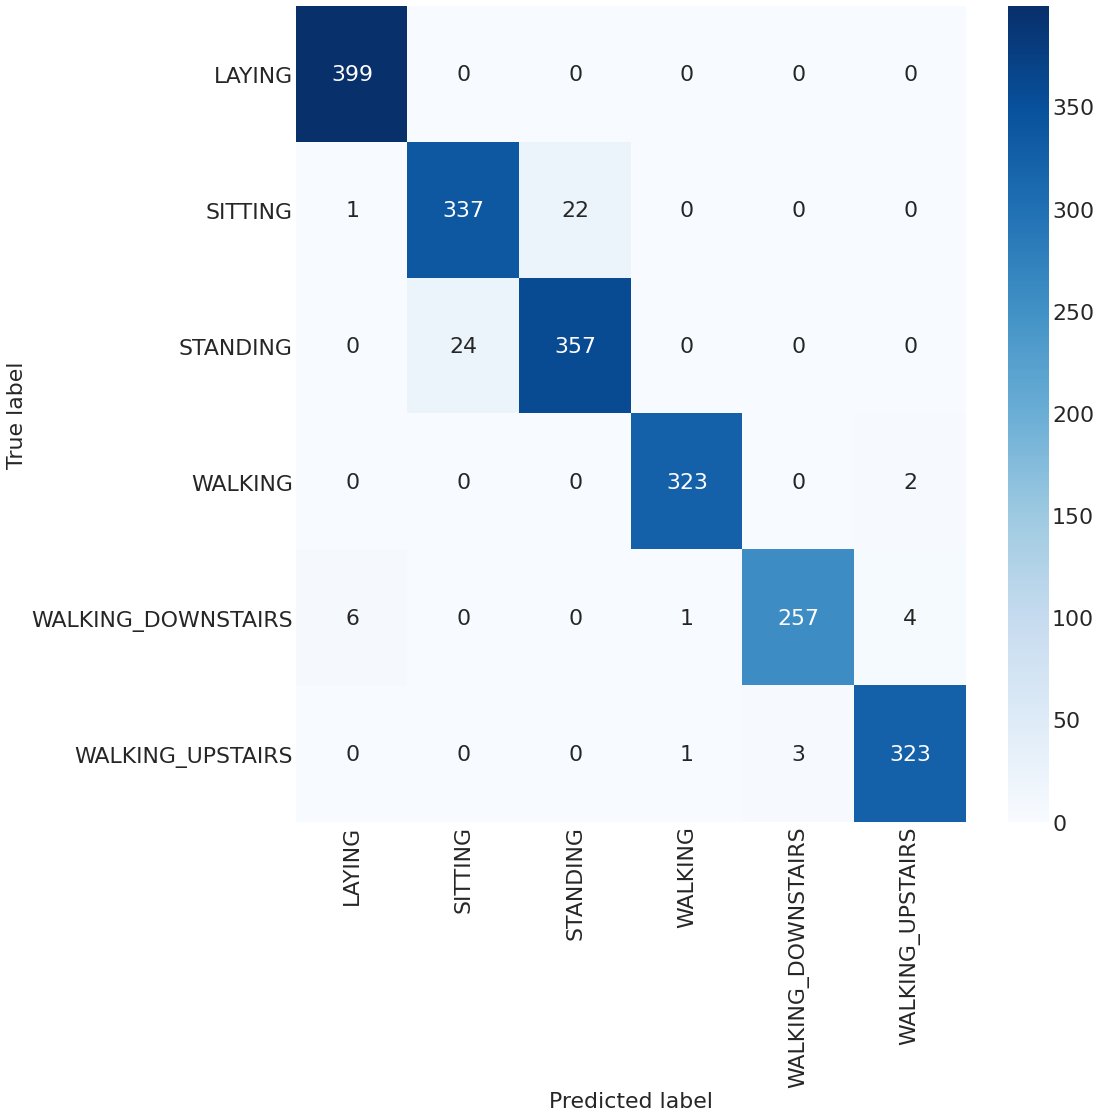

In [29]:
import seaborn as sn
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import zscore

cm = confusion_matrix(y_test_set,y_pred)
#cm =zscore(cm)

df_cm = pd.DataFrame(cm, index = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'], 
                     columns = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams.update({'font.size': 22})
    plt.rc('axes', titlesize=22)     # fontsize of the axes title
    plt.rc('axes', labelsize=22)
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig, ax = plt.subplots(figsize=(15, 15))
    

    sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g', ax=ax)
    plt.xlabel('Predicted label')
    plt.ylabel('True label', rotation='vertical')

#plot_confusion_matrix(gda, x_test_set, y_test_set, cmap=plt.cm.Blues, normalize=True, ax=ax)
#plt.xticks(rotation='vertical')
#plt.show()

### 4.2 SVM final

In [ ]:
svd = TruncatedSVD(n_components=310)
x_train_set_r = svd.fit_transform(x_train_set)
x_test_set_r = svd.transform(x_test_set)

In [ ]:
svclassifier = SVC(kernel='rbf', C=100.0, gamma=0.01)
svclassifier.fit(x_train_set_r, y_train_set)

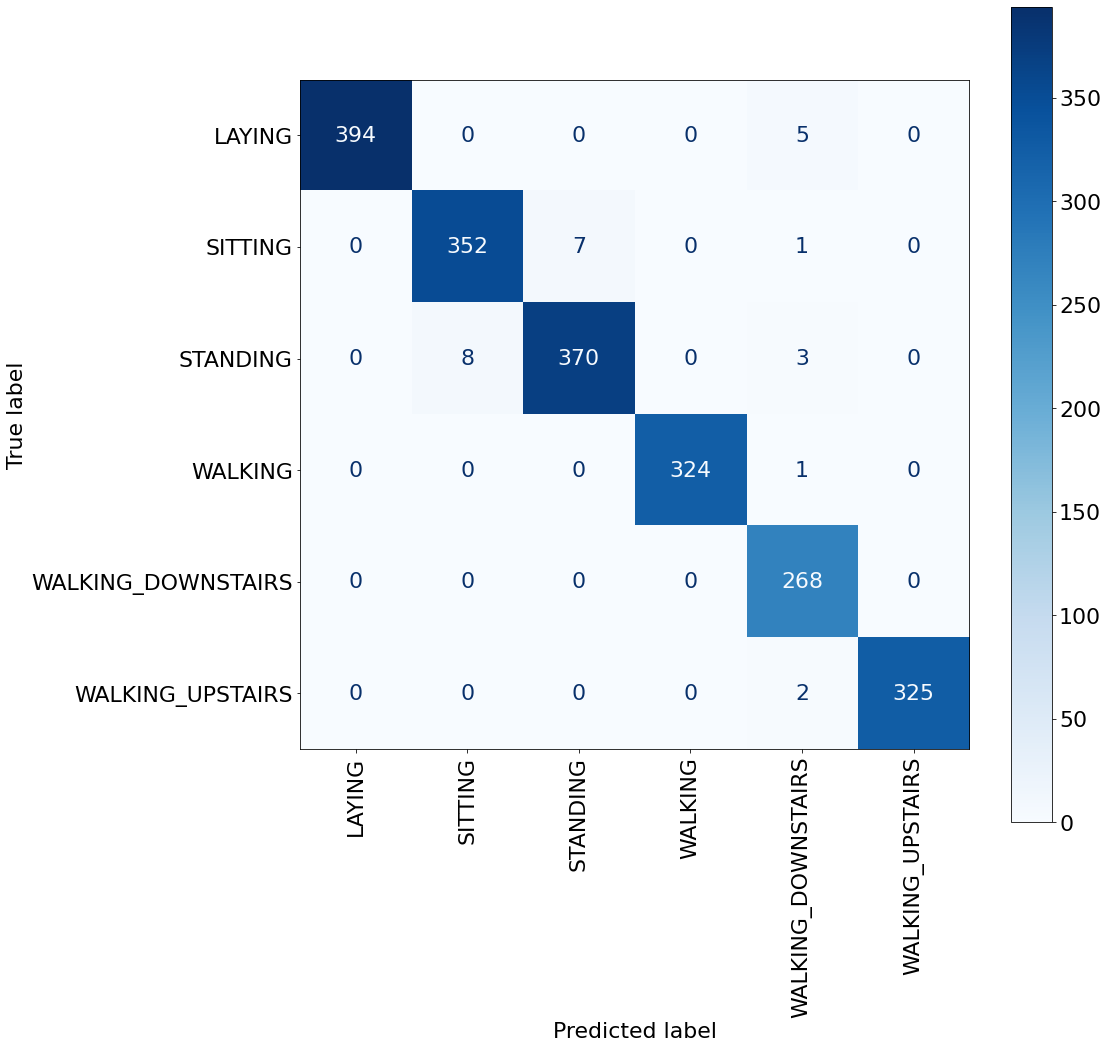

In [36]:
import matplotlib

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 22})
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)
plot_confusion_matrix(svclassifier, x_test_set_r, y_test_set, cmap=plt.cm.Blues, normalize=True, ax=ax)
plt.xticks(rotation='vertical')
plt.show()